<a href="https://colab.research.google.com/github/marypthomas/ai-bootcamp-osu/blob/main/Session_9/MLP_Intro_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connecting Theory to Practice: Building Neural Networks**
**Author**:
- Prof. Eric Fosler-Lussier, The Ohio State University

## **A PyTorch Tutorial: Single Layer and Multilayer Neural Networks**


This in-class exercise helps you connect the theory we've been learning to implementation in PyTorch.

In this first example we are going to look at developing a linear regression (1-layer) model for a 2-dimensional problem.  This first code block is about setup: we'll pick 100 random points according to some linear function y=w0+w1x1+w2x2, where we pick weights ahead, but also add some random noise.

Since we've already done linear regression, you can hopefully move quickly through the data generation phase and look at the pytorch code.  This will help you build a multilayer network later.


## **Programming Notes**  
* The data and weights are similar to the way they were set up  in  the previous exercises: each row is a different feature or the bias.  However, PyTorch expects its input in the transposed manner (columns are features/bias). The representation is not corrected; rather we will resort to transpositions in the code.  
* The first example does the transposition on matrices; this won't work for vectors so in the second example we  change the view of the data within the forward function.
* PyTorch likes for its objects in default to be 32-bit floats; numpy tends to give 64-bit floats.  You'll see a bit of casting here and there.
* You may want to reference the pytorch and numpy reference manuals:
https://pytorch.org/docs/stable/index.html
https://numpy.org/doc/1.18/reference/index.html


## **Data Generation**

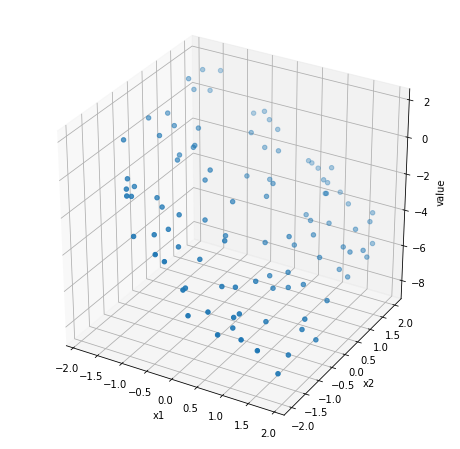

In [ ]:
### Data generation: you can skip through this quickly, generate 100 random points, plot...

# this first import allows for 3d plots, but isn't actually used
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

# randomly pick 100 points and compute y= w0+w1x1+w2x2 + randomerror
npoints=100

# set a particular function to learn: y= -3 -2x1 +x2, so w=[-3,-2,1]
trueweights=np.array([-3,-2,1])

# set the bias input to 1 for all datapoints, and randomly distribute between -2 and 2 for x1, x2
datapoints=np.vstack((np.ones((1,npoints),dtype=np.float32),np.float32(np.random.rand(2,npoints)*4.0-2.0)))

# compute the values by y= -3 -2x1 +x2 + some random value between -0.5 and +0.5
values=np.float32(np.matmul(trueweights,datapoints)+(np.random.rand(1,npoints)-0.5))

# plot the values in 3d as a scatter plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datapoints[1,:],datapoints[2,:],values,marker='o')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('value')

plt.show()


## **Learning a Linear Model** 

In the next section, I demonstrate how to set up PyTorch to learn a linear regression using stochastic gradient descent.  Note how the linear regression function is a class that has both an initializer (which sets up one layer) and a forward function that defines how the output is created.  The optimizer and criterion will use this definition to determine gradients.

In [ ]:
# now let's set up pytorch to learn this function
# this example adapted from https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

import torch
from torch.autograd import Variable

# Define a learner class, decended from torch.nn.Module
# This class should have two methods:
#
# __init__: an initialization routine which allocates the weight matrices of the network
#
# forward: the logical chain of computation for computing the output of the network
#
# The forward result should use torch layers that are differentiable. 
# This way PyTorch can automatically compute the gradient for the optimizer.
# The optimizer can then use the loss gradients to update the parameters

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        # initialize any parent classes
        super(linearRegression, self).__init__()
        
        # this next line creates a single linear layer, which we will store as "linear"
        # there is nothing special about self.linear as a name, we could have called it self.elmer
        #   ... as long as we referened it correctly in the forward pass
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        # for a linear regression, out = weights * x
        # the linear layer applied to input creates the output
        out = self.linear(x)
        return out


Now let's set up the rest of the learning system. We'll set a number of parameters, and create a criterion object and an optimizer object.

Another programming note: while I needed the bias to generate the data (or I could have hard coded it) it turns out the PyTorch has a flag for representing the bias in any layer, so we'll strip off the 1's on our data in the last line.

In [ ]:
# set parameters for this experiment
inputDim = 2        # torch.nn.Linear assumes bias weight by default, so only need 2 dims
outputDim = 1       # predicted variable
learningRate = 0.01 # this is our step size
epochs = 100        # maximum number of epochs

# create a model for our specific problem size (2 in, 1 out, bias true)
model = linearRegression(inputDim, outputDim)

# Set up the GPU if it is available.  Not really needed for this problem, but
# if you have the GPU available it might be faster. Probably not for this problem.
if torch.cuda.is_available():
    model.cuda()

# You can choose among a variety of loss functions.  MSE loss is most appropriate
# for linear regression.
criterion = torch.nn.MSELoss() 

# Create an optimizer that uses Stochastic Gradient Descent, and let it know
# about your model's parameters.
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# strip off the 1's we had before for the bias.
data=datapoints[1:3,:].T



At this point we will create a simple learning loop that runs batch mode over all of the datapoints (collecting gradients from all examples in the training set).  We run for exactly the number of epochs in our paramter setting.

In [ ]:
# Now we will train the linear regression for the maximum number of epochs.

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(data).cuda())
        labels = Variable(torch.from_numpy(values.T).cuda())
    else:
        inputs = Variable(torch.from_numpy(data))
        labels = Variable(torch.from_numpy(values.T))

    # Clear gradient buffers because we don't want gradients from previous epoch
    # to carry forward (no gradient accumulation)
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    #   note that "loss" for PyTorch is an object that has access to the model
    #   so that it can create the gradents for the model
    loss = criterion(outputs, labels)
    print(loss)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    
    

tensor(14.9684, grad_fn=<MseLossBackward0>)
epoch 0, loss 14.968398094177246
tensor(14.3067, grad_fn=<MseLossBackward0>)
epoch 1, loss 14.306732177734375
tensor(13.6752, grad_fn=<MseLossBackward0>)
epoch 2, loss 13.675175666809082
tensor(13.0723, grad_fn=<MseLossBackward0>)
epoch 3, loss 13.072325706481934
tensor(12.4968, grad_fn=<MseLossBackward0>)
epoch 4, loss 12.496847152709961
tensor(11.9475, grad_fn=<MseLossBackward0>)
epoch 5, loss 11.947464942932129
tensor(11.4230, grad_fn=<MseLossBackward0>)
epoch 6, loss 11.422968864440918
tensor(10.9222, grad_fn=<MseLossBackward0>)
epoch 7, loss 10.922203063964844
tensor(10.4441, grad_fn=<MseLossBackward0>)
epoch 8, loss 10.444069862365723
tensor(9.9875, grad_fn=<MseLossBackward0>)
epoch 9, loss 9.987520217895508
tensor(9.5516, grad_fn=<MseLossBackward0>)
epoch 10, loss 9.551559448242188
tensor(9.1352, grad_fn=<MseLossBackward0>)
epoch 11, loss 9.135232925415039
tensor(8.7376, grad_fn=<MseLossBackward0>)
epoch 12, loss 8.737640380859375
tens

Let's print out the learned parameters and see if they match our input.

In [ ]:
for param in model.parameters():
  print(param.data)



tensor([[-1.9503,  0.8842]])
tensor([-2.5899])


Not bad!  Try modifying the data, regenerate and run again.

Thought experiments (or implement if you wish):


*   The learning loop runs for a fixed number of epochs.  How would you modify to incorporate a stopping criterion based on how well the model fits?
*   The learning loop runs in batch mode.  How would you update it so that it runs in online mode?  How about in mini-batch mode?





## **Building Encoders**

Let's try something different: a 4-2-4 encoder (or n-k-n encoder).

The idea is that in a 4-2-4 encoder, one input is on, and the others are off; the output should be the same as the input.  The smaller hidden layer acts as a compression.

Notice that with a one-hot encoding (see enc_data below) there are n possible inputs.  This, in theory, can be encoded as a k=ceiling(log2(n)) bit sequence.

Based on the two examples above, create the encoder object.  There is a first linear layer, followed by a sigmoid; then a second linear layer followed by a sigmoid.




In [ ]:
# this sets up a random permutation of one hot encoding
enc_data=np.random.permutation(np.diag(np.ones(4,dtype=np.float32)))

# print out the encoded data 
enc_data

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

Define your main class.  You will want to set up a forward function that uses

linear layer -> sigmoid -> linear layer -> sigmoid

The key functions are ```torch.nn.Linear()``` and ```torch.nn.Sigmoid()```.


In [ ]:
class nkn_encoder(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(nkn_encoder, self).__init__()
        ###
        ### define your encoder object here
        ###

    def forward(self, x):
        ###
        ### define a forward function for your network
        ###
        return out

    def encode(self, x):
        ###
        ### create a function similar to forward that returns the hidden layer
        ###
        return hidden
        

In [ ]:
class nkn_encoder(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(nkn_encoder, self).__init__()
        
        self.layer1=torch.nn.Linear(inputSize, hiddenSize)
        self.sigmoid=torch.nn.Sigmoid()
        self.layer2=torch.nn.Linear(hiddenSize, inputSize)

    def forward(self, x):
        
        x=self.layer1(x)
        x=self.sigmoid(x)
        x=self.layer2(x)
        out=self.sigmoid(x)
        return out

    def encode(self, x):
        x=self.layer1(x)
        hidden=self.sigmoid(x)
        return hidden

In [ ]:
model424=nkn_encoder(4,2)

if torch.cuda.is_available():
    model424.cuda()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model424.parameters(), lr=0.05)

For the sake of time, here is a test harness for your code.

In [ ]:
for epoch in range(100000):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(enc_data.T).cuda())
        labels = Variable(torch.from_numpy(enc_data.T).cuda())
    else:
        inputs = Variable(torch.from_numpy(enc_data.T))
        labels = Variable(torch.from_numpy(enc_data.T))

    # Clear gradient buffers because we don't want gradients from previous epoch
    # to carry forward (no gradient accumulation)
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model424(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    if (epoch % 1000 == 0):
      print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.26798996329307556
epoch 1000, loss 0.18838615715503693
epoch 2000, loss 0.1852145791053772
epoch 3000, loss 0.18274712562561035
epoch 4000, loss 0.17912572622299194
epoch 5000, loss 0.1735718548297882
epoch 6000, loss 0.1654035747051239
epoch 7000, loss 0.15444301068782806
epoch 8000, loss 0.14154957234859467
epoch 9000, loss 0.12840324640274048
epoch 10000, loss 0.11642176657915115
epoch 11000, loss 0.1061934158205986
epoch 12000, loss 0.09774649143218994
epoch 13000, loss 0.090888112783432
epoch 14000, loss 0.08535707741975784
epoch 15000, loss 0.08088868856430054
epoch 16000, loss 0.07724975049495697
epoch 17000, loss 0.0742519199848175
epoch 18000, loss 0.07175029814243317
epoch 19000, loss 0.06963581591844559
epoch 20000, loss 0.06782663613557816
epoch 21000, loss 0.06626111268997192
epoch 22000, loss 0.0648922398686409
epoch 23000, loss 0.06368370354175568
epoch 24000, loss 0.062607042491436
epoch 25000, loss 0.061639655381441116
epoch 26000, loss 0.06076328083872

We can print out the predicted encoding of the input. Does it do what you expect?

In [ ]:
with torch.no_grad():
  if torch.cuda.is_available():
        predicted = model424.encode(Variable(torch.from_numpy(enc_data.T).cuda())).cpu().data.numpy()
  else:
        predicted = model424.encode(Variable(torch.from_numpy(enc_data.T))).data.numpy()
  print(predicted)

[[0.9498595  0.9823398 ]
 [0.00972246 0.8857086 ]
 [0.12877885 0.01837777]
 [0.982698   0.02929348]]


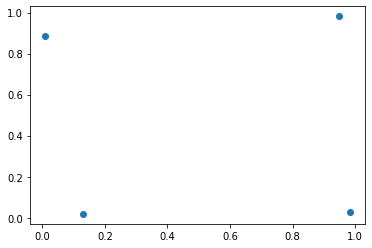

In [ ]:
plt.plot(predicted[:,0],predicted[:,1],'o')

Now: what if you tried n-k-n for n=8 (what should k at least be?)  What if k=n?  What happens if you try to change nonlinearites to ReLU for example.  Experiment!